In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy.fft import fft
from IPython.display import display, Markdown, Latex

from sklearn import linear_model # apply linear model
from sklearn.preprocessing import PolynomialFeatures # apply quadratic model
import statsmodels.api as sm # apply Baxter-King and Hodrick-Prescott filters
import quantecon # apply Hamilton Filter

In [2]:
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option("display.notebook_repr_html", True)
def _repr_latex_(self):
    return "\centering{%s}" % self.to_latex()
pd.DataFrame._repr_latex_ = _repr_latex_

%matplotlib inline
%config InlineBackend.figure_format = "retina"

font = FontProperties()
font.set_family("serif")
font.set_name("Times New Roman")

In [18]:
df = pd.read_excel(r"Brazilian Data.xlsx", sheet_name=0)

df = df.loc[0:104]
df["Employment"] = np.log(df["Employment"])
df["Working People"] = np.log(df["Working People"])

df2 = df.loc[:,"Consumption of Non-Durables":"Government Expenditures"]
df3 = df.loc[:, "GDP [Q]":"Government Expenditures"]

In [4]:
def linear_filter(data):   

    y = pd.DataFrame(data)
    y = y.dropna()

    x = y.index
    x = sm.add_constant(x)

    reg = sm.OLS(y, x).fit()
    resid = pd.DataFrame(reg.resid)
    resid = resid.rename(columns={resid.columns[0]: data.name})

    return resid

In [5]:
def quadratic_filter(data):

    y = pd.DataFrame(data)
    y = y.dropna()

    y["const"] = 1
    y["index"] = y.index
    y["indexsq"] = y.index**2

    reg = sm.OLS(y[data.name], y[["const", "index", "indexsq"]]).fit()
    resid = pd.DataFrame(reg.resid)
    resid = resid.rename(columns={resid.columns[0]: data.name})

    return resid

In [6]:
def hp_filter(data):

    y = pd.DataFrame(data)
    y = y.dropna()

    cycle, trend = sm.tsa.filters.hpfilter(y, 1600)
    cycle = cycle.to_frame()
    cycle = cycle.rename(columns={cycle.columns[0]: data.name})

    return cycle

In [7]:
def bk_filter(data):

    y = pd.DataFrame(data)
    y = y.dropna()

    cycle = sm.tsa.filters.bkfilter(y, 6, 24, 12)
    cycle = cycle.rename(columns={cycle.columns[0] : data.name})

    return cycle

In [8]:
def hamilton_filter(data):

    y = data
    y = y.dropna()

    cycle, trend = quantecon.filter.hamilton_filter(y, 8, 4)
    
    dfcycle = pd.DataFrame(cycle)
    dfcycle = dfcycle.dropna().rename(columns={dfcycle.columns[0]: data.name})
    
    return dfcycle

In [9]:
filter_dict = {"Linear Filter" : linear_filter, "Quadratic Filter" : quadratic_filter, "HP Filter" : hp_filter, "BK Filter" : bk_filter, "Hamilton Filter" : hamilton_filter}

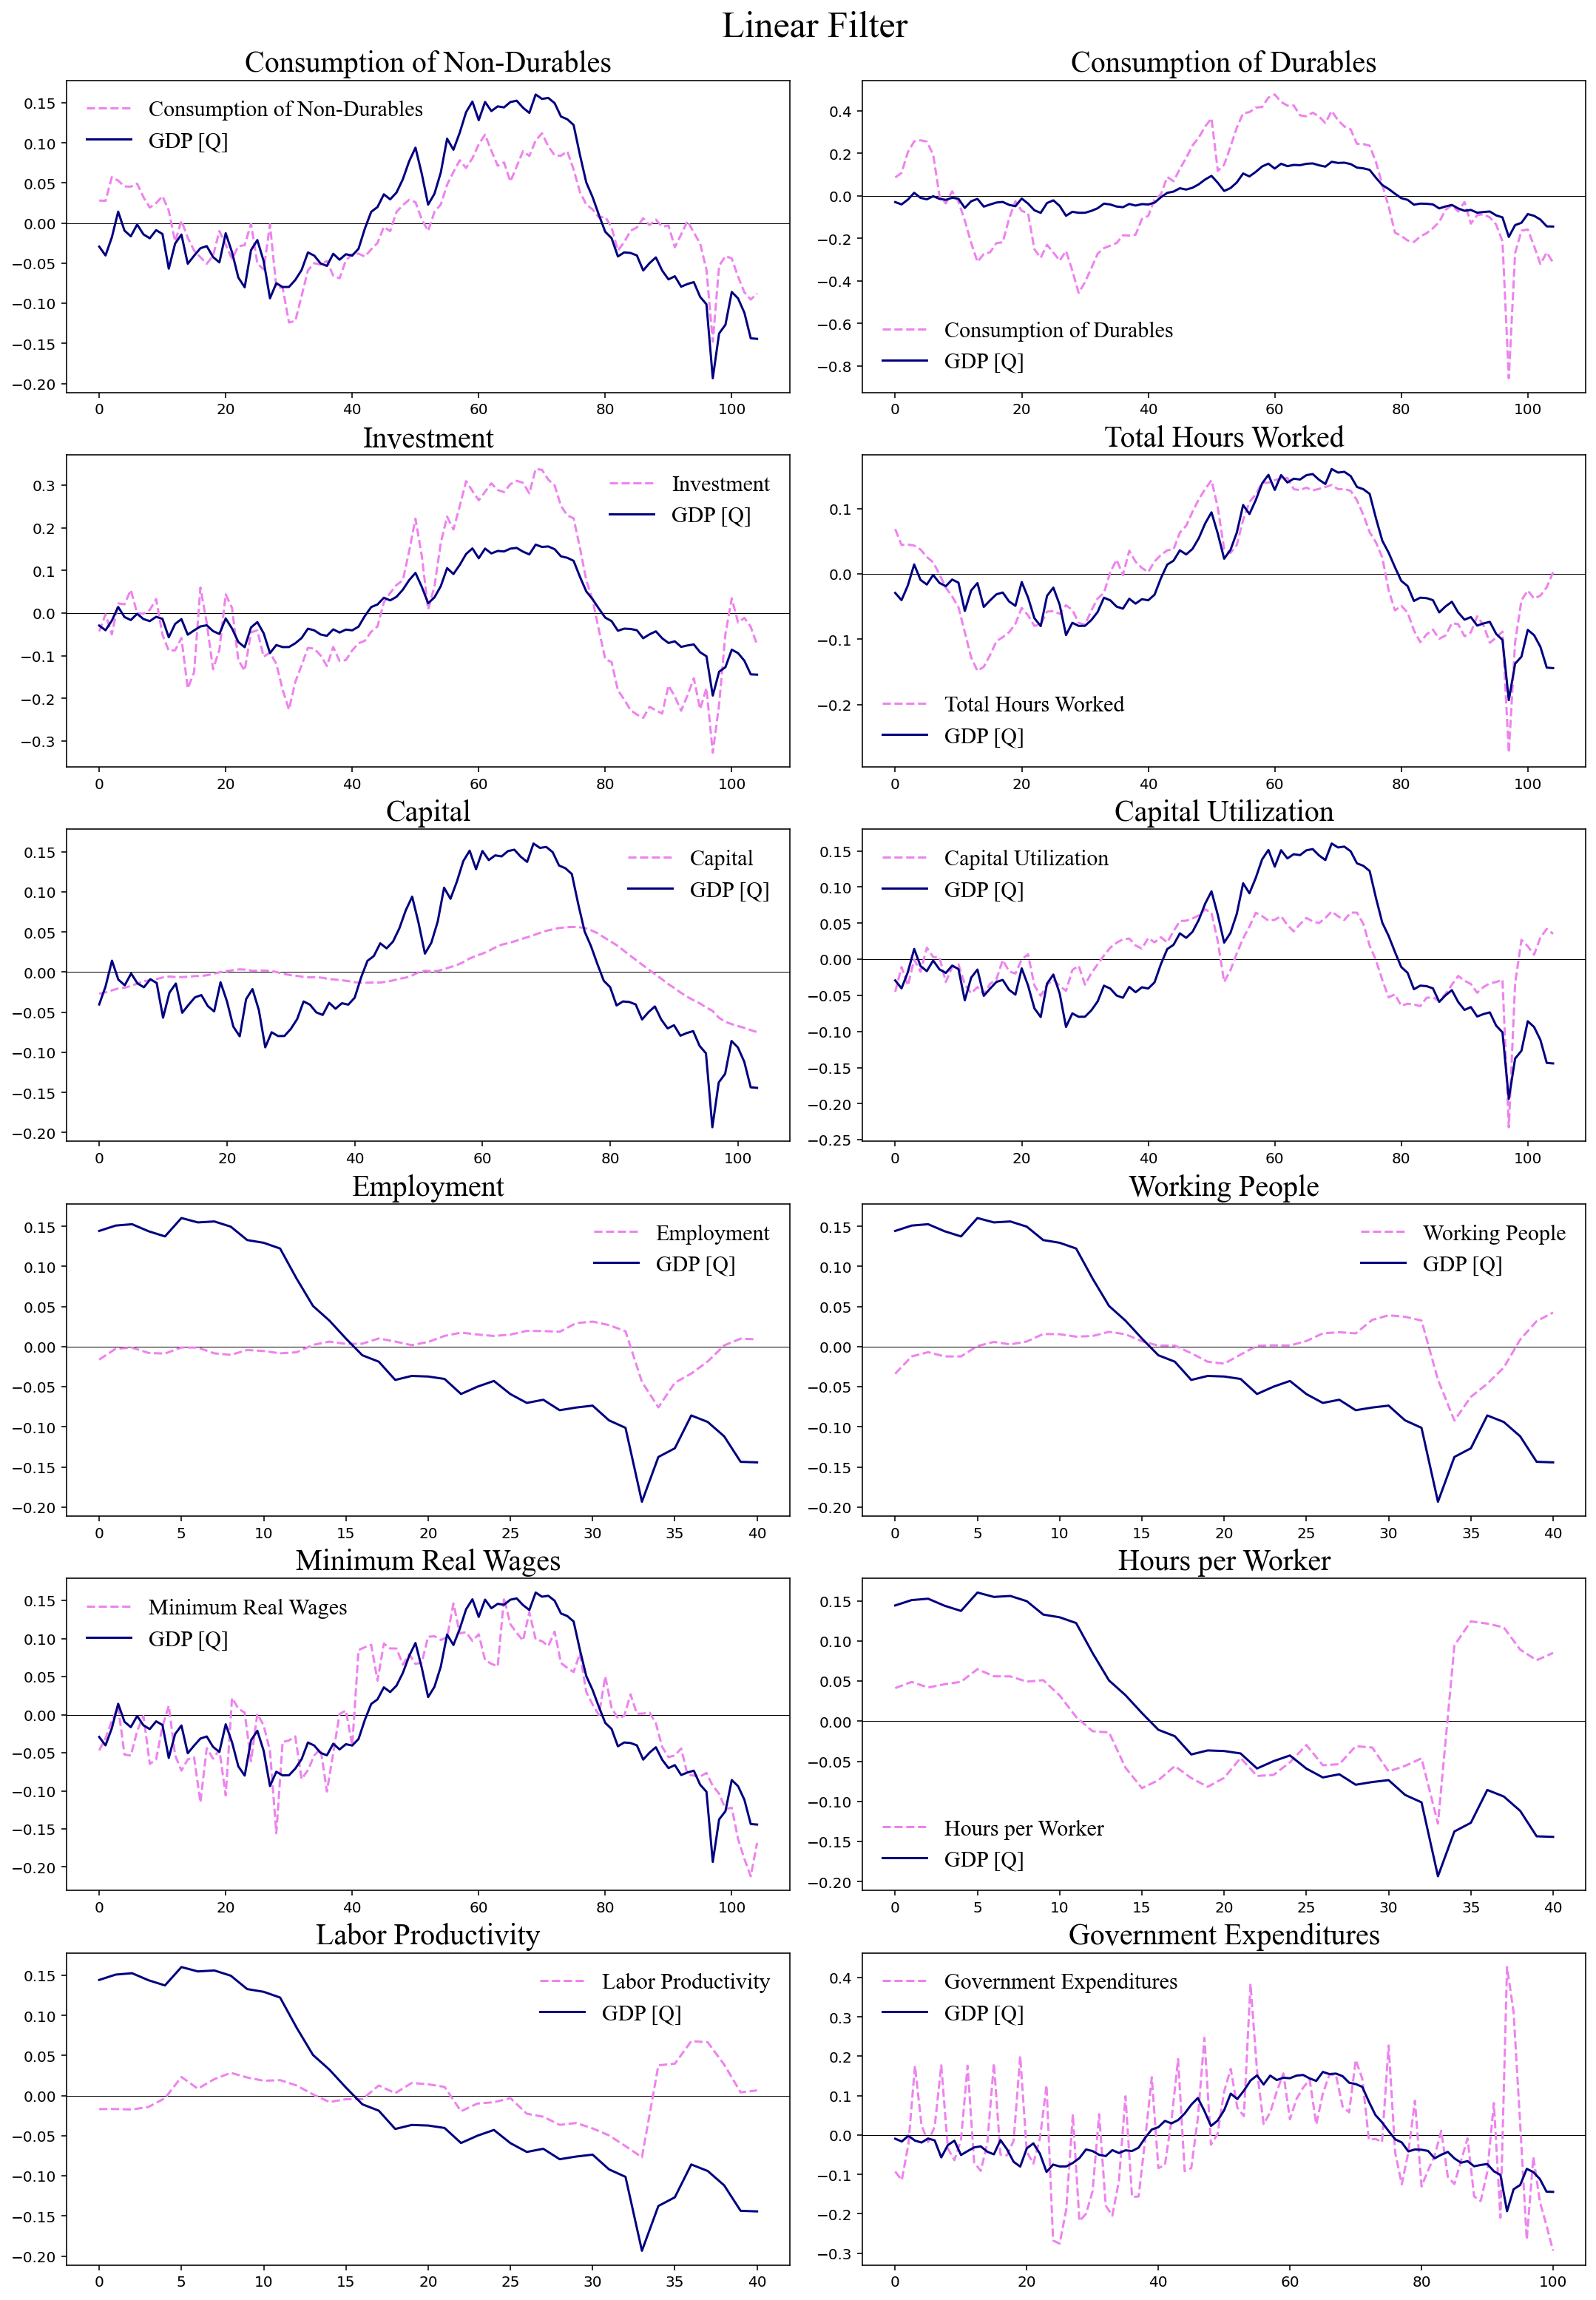

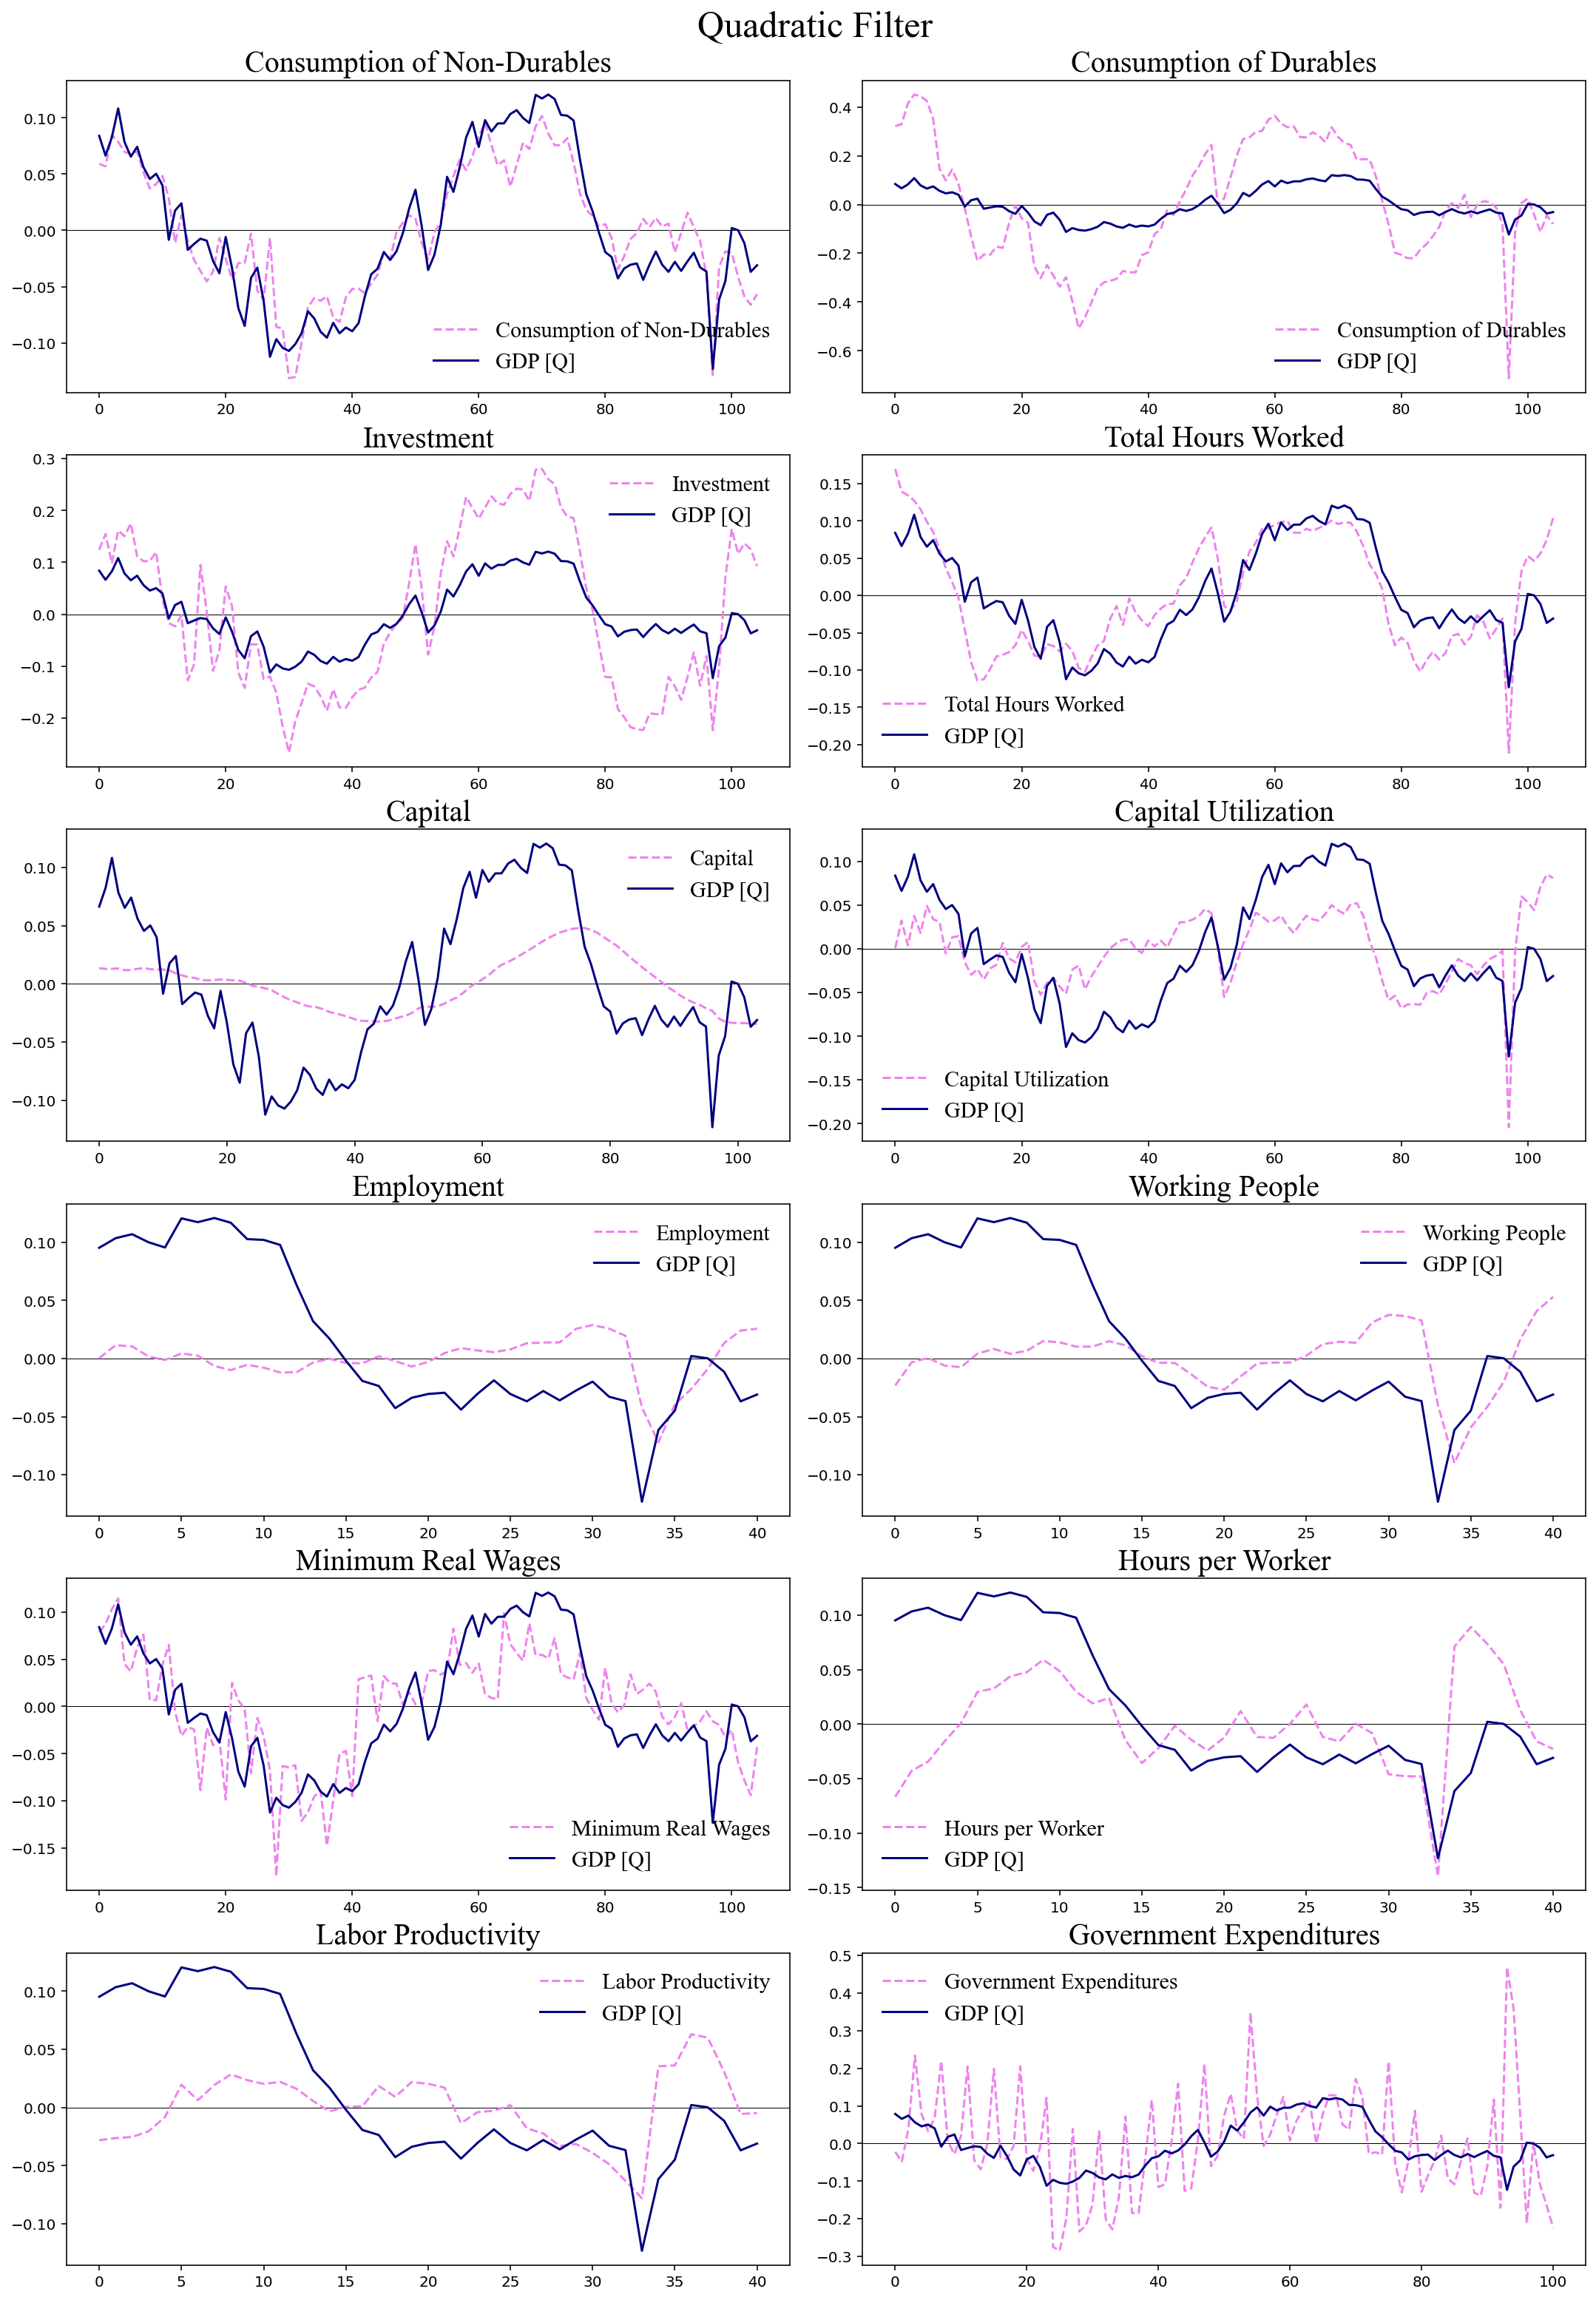

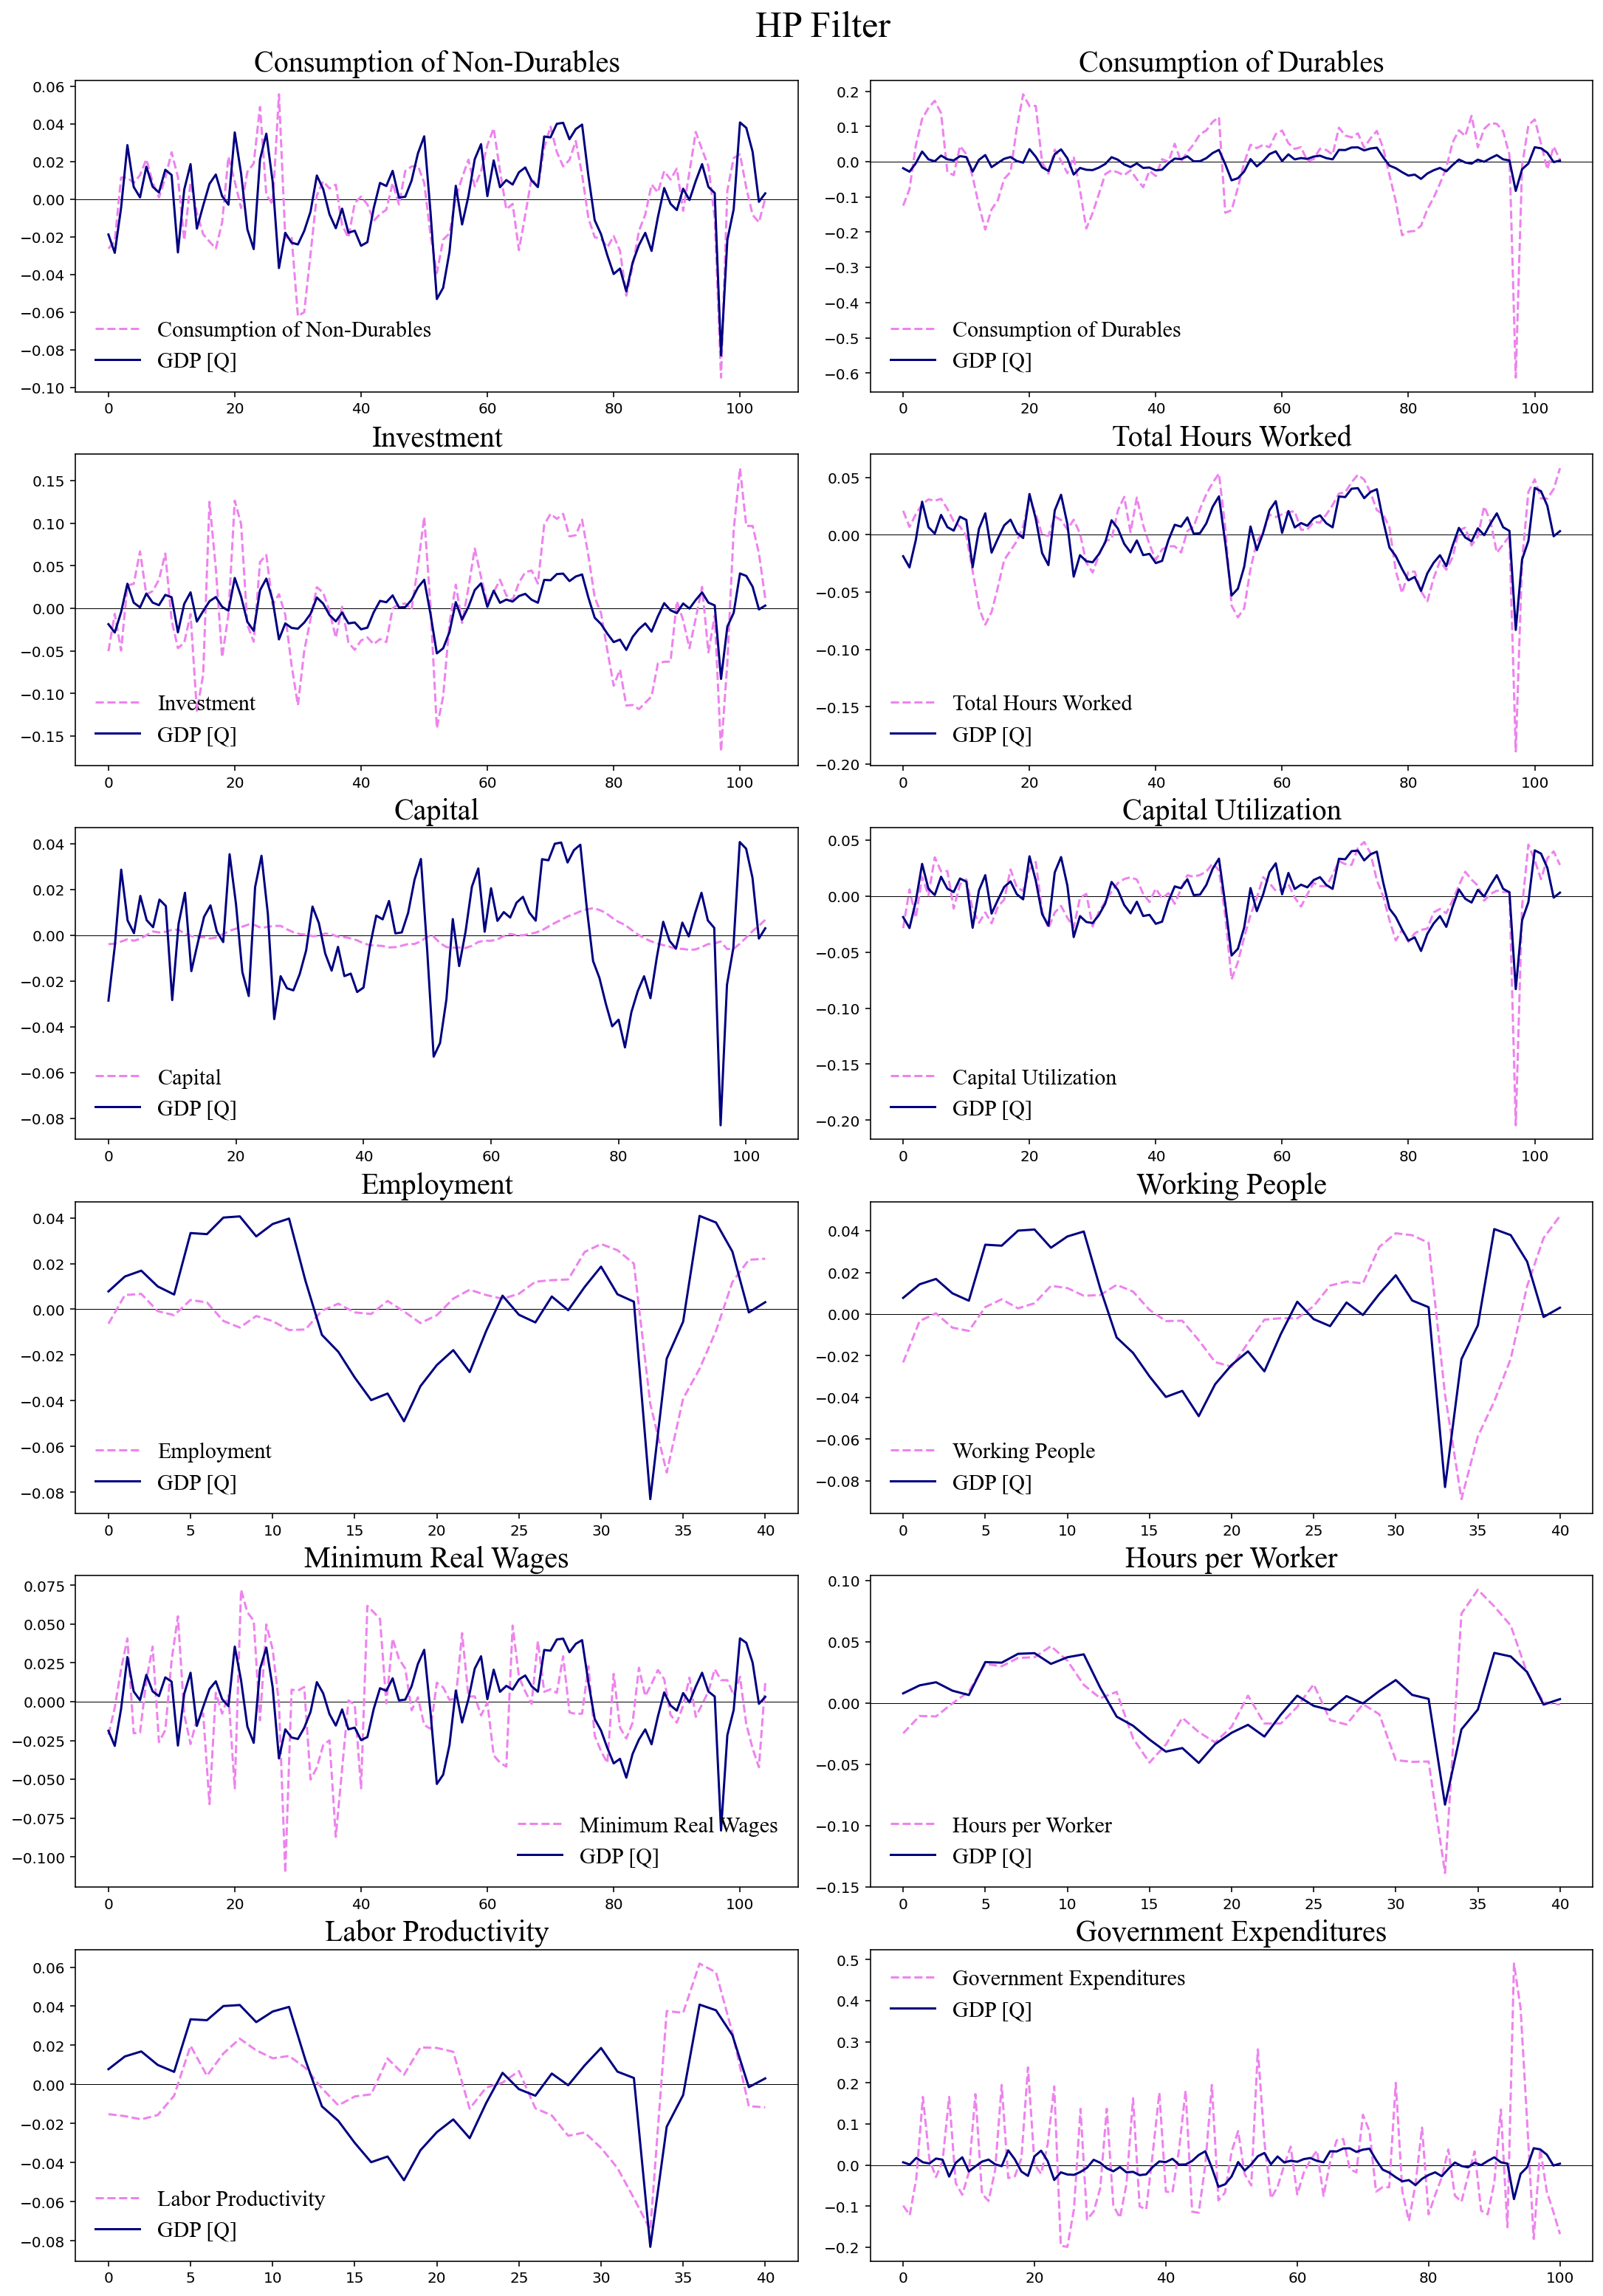

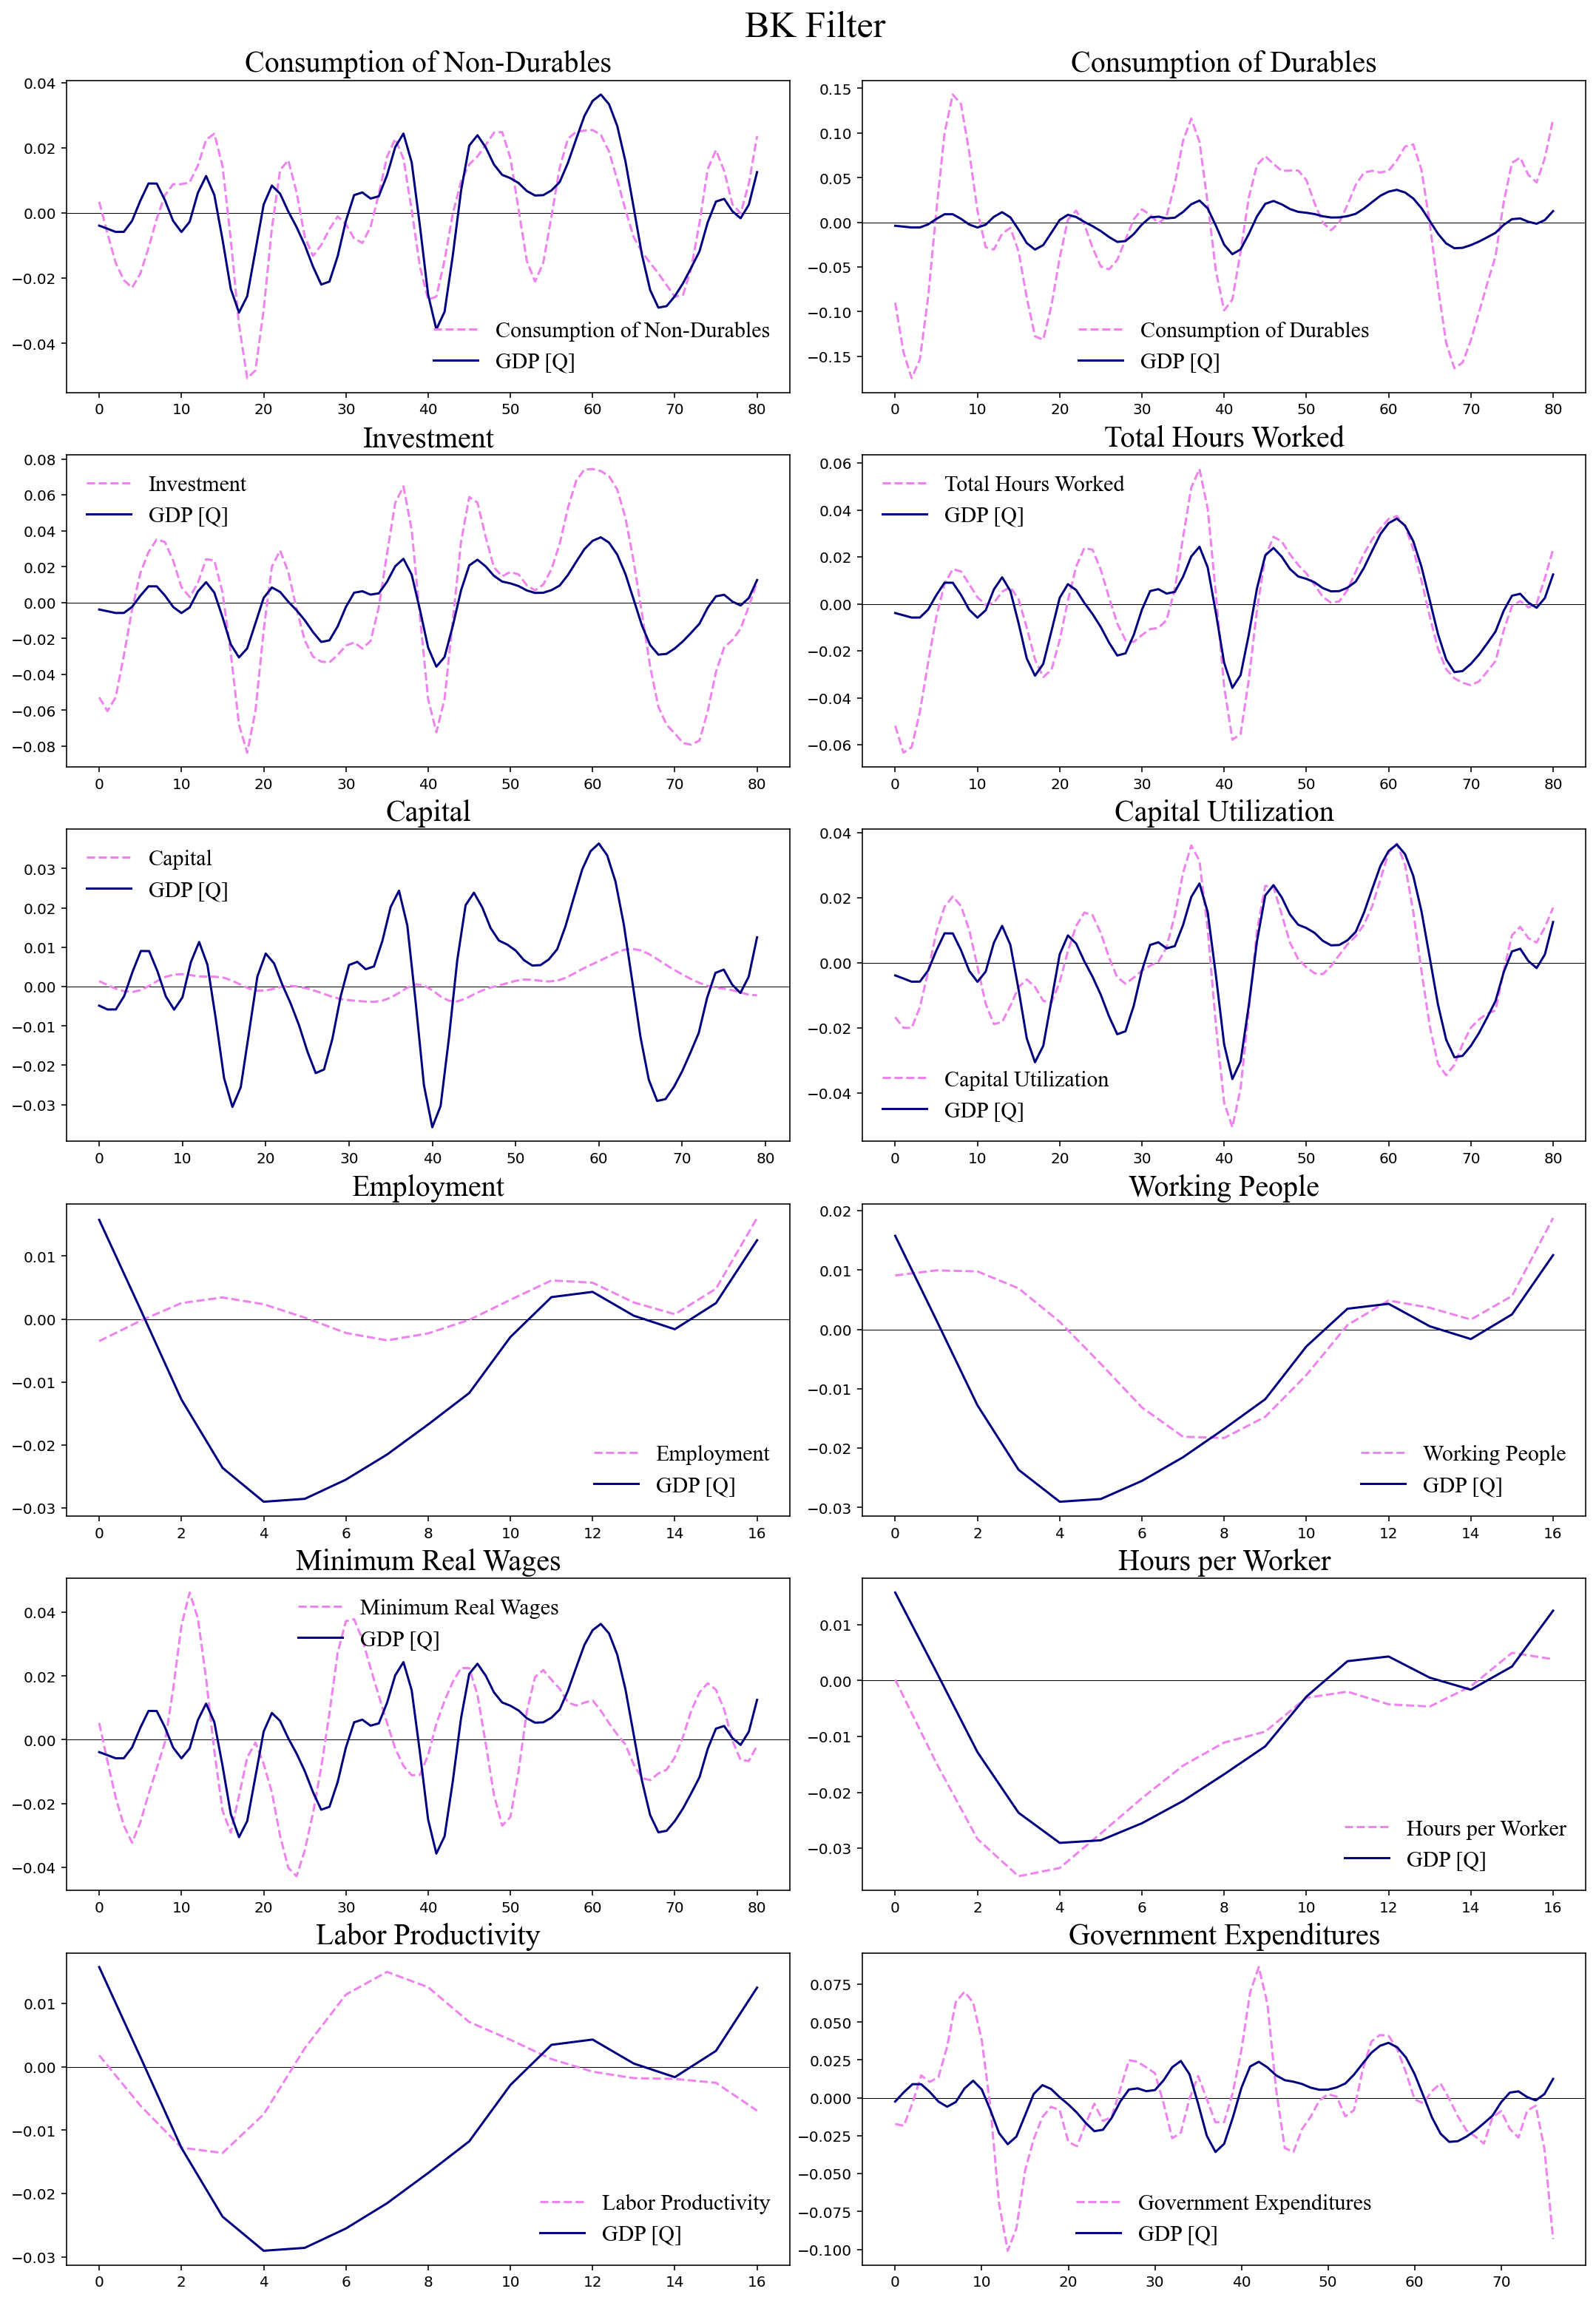

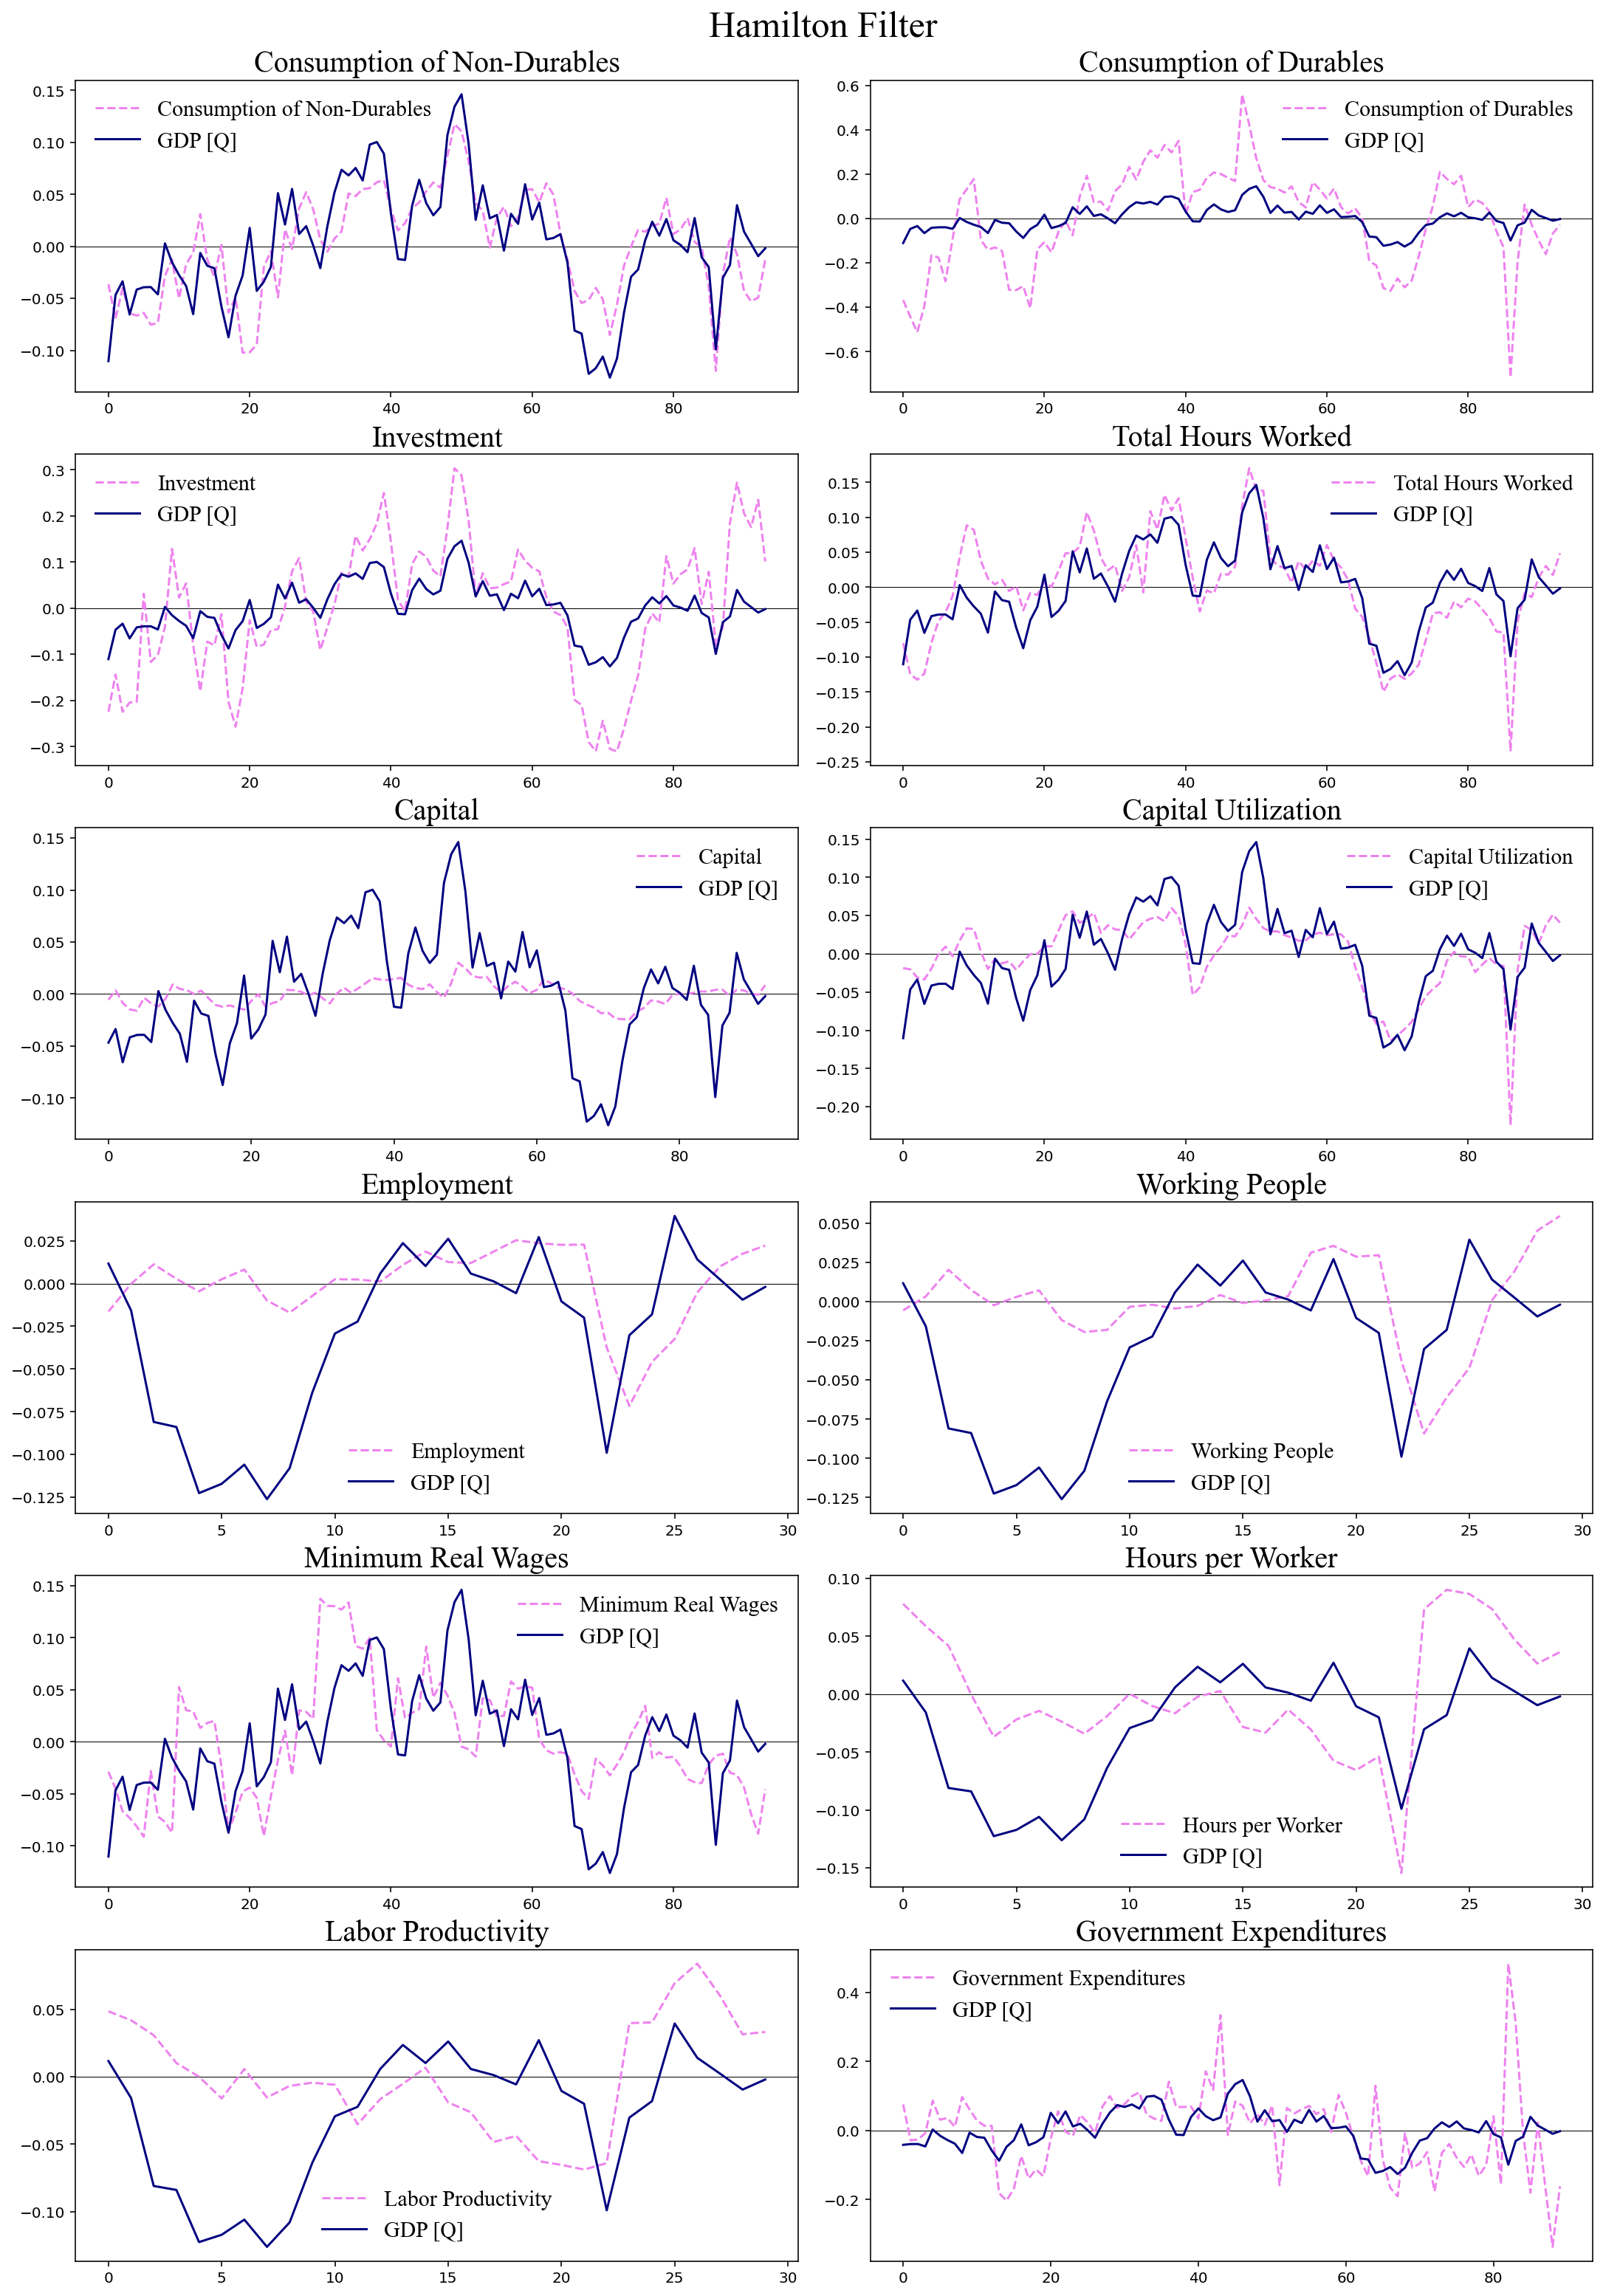

In [10]:
for i in filter_dict:
    fig, axs = plt.subplots(6, 2, figsize = (15,22))
    fig.suptitle(i, fontsize = 25, fontproperties = font)
    fig.tight_layout()
    fig.subplots_adjust(wspace = 0.1, hspace = 0.20, top = 0.95)

    for column, ax in zip(df2.columns, axs.ravel()):
        x = filter_dict[i](df2[column]).reset_index().drop(columns = ["index"])
        y = filter_dict[i](df["GDP [Q]"])[-len(x):].reset_index().drop(columns = ["index"])

        ax.set_title(column, fontsize = 20, fontproperties = font)
        ax.axhline(0, color = "black", ls = "-", linewidth = 0.5)
        x.plot(ax = ax, color = "violet", style = "--")
        y.plot(ax = ax, color = "navy")
        ax.legend(frameon = False, prop = {"size": 15, "family" : "Times New Roman"})

In [11]:
tables_dict = {filter_ : pd.DataFrame(index = df3.columns) for filter_ in filter_dict}

In [12]:
def filter_tables(benchmark):
    for filter_ in filter_dict.keys():
        table = tables_dict[filter_]
        for column in df3.columns:
            table.loc[column, "SD"] = np.std(filter_dict[filter_](df[column]))[0]
            table.loc[column, "RSD"] = np.std(filter_dict[filter_](df[column]))[0]/np.std(filter_dict[filter_](df[benchmark]))[0]
            table.loc[column, "FOAC"] = sm.tsa.acf(filter_dict[filter_](df[column]).dropna(), nlags = 1, fft = False)[1]

            gdp = pd.DataFrame()
            gdp[benchmark] = df[benchmark]
            gdp[column] = df[column]
            gdp = gdp.dropna()
            table.loc[column, "CCO"] = np.corrcoef(filter_dict[filter_](gdp[column])[column].dropna(), filter_dict[filter_](gdp[benchmark])[benchmark].dropna())[0,1]
        tables_dict[filter_] = table

In [13]:
filter_tables("GDP [Q]")

In [14]:
for filter_, i in zip(filter_dict.keys(), range(len(filter_dict.keys()))):
    print("\n")
    display(Markdown(f"Table {i + 1} - {filter_}"))
    display(tables_dict[filter_])

Table 1 - Linear Filter

SD  RSD  FOAC   CCO
GDP [Q]                     0.08 1.00  0.95  1.00
Consumption of Non-Durables 0.06 0.67  0.90  0.85
Consumption of Durables     0.26 3.15  0.91  0.89
Investment                  0.17 2.04  0.94  0.91
Total Hours Worked          0.09 1.06  0.94  0.84
Capital                     0.03 0.36  0.96  0.77
Capital Utilization         0.05 0.55  0.74  0.66
Employment                  0.02 0.25  0.77 -0.08
Working People              0.03 0.32  0.73  0.23
Minimum Real Wages          0.08 0.96  0.86  0.83
Hours per Worker            0.07 0.80  0.79  0.74
Labor Productivity          0.03 0.36  0.72  0.51
Government Expenditures     0.14 1.69  0.32  0.41

Table 2 - Quadratic Filter

SD  RSD  FOAC  CCO
GDP [Q]                     0.07 1.00  0.94 1.00
Consumption of Non-Durables 0.05 0.83  0.90 0.92
Consumption of Durables     0.24 3.67  0.89 0.88
Investment                  0.15 2.32  0.92 0.90
Total Hours Worked          0.08 1.15  0.88 0.78
Capital                     0.02 0.36  0.98 0.63
Capital Utilization         0.04 0.62  0.66 0.53
Employment                  0.02 0.29  0.72 0.11
Working People              0.03 0.40  0.71 0.36
Minimum Real Wages          0.06 0.85  0.75 0.71
Hours per Worker            0.04 0.65  0.52 0.69
Labor Productivity          0.03 0.45  0.71 0.49
Government Expenditures     0.14 2.10  0.30 0.35

Table 3 - HP Filter

SD  RSD  FOAC   CCO
GDP [Q]                     0.02 1.00  0.59  1.00
Consumption of Non-Durables 0.02 1.00  0.51  0.59
Consumption of Durables     0.11 4.71  0.53  0.69
Investment                  0.07 2.85  0.63  0.82
Total Hours Worked          0.04 1.53  0.62  0.70
Capital                     0.00 0.19  0.95  0.24
Capital Utilization         0.03 1.30  0.40  0.73
Employment                  0.02 0.80  0.71  0.20
Working People              0.03 1.13  0.71  0.35
Minimum Real Wages          0.03 1.34  0.24  0.01
Hours per Worker            0.04 1.77  0.52  0.64
Labor Productivity          0.03 1.15  0.65  0.46
Government Expenditures     0.12 5.24  0.08 -0.16

Table 4 - BK Filter

SD  RSD  FOAC   CCO
GDP [Q]                     0.02 1.00  0.88  1.00
Consumption of Non-Durables 0.02 1.09  0.84  0.72
Consumption of Durables     0.08 4.66  0.86  0.75
Investment                  0.04 2.61  0.89  0.88
Total Hours Worked          0.03 1.58  0.86  0.79
Capital                     0.00 0.20  0.97  0.25
Capital Utilization         0.02 1.12  0.86  0.79
Employment                  0.00 0.28  0.37  0.42
Working People              0.01 0.65  0.74  0.58
Minimum Real Wages          0.02 1.18  0.88  0.17
Hours per Worker            0.01 0.77  0.80  0.85
Labor Productivity          0.01 0.49  0.79 -0.18
Government Expenditures     0.03 2.08  0.77  0.46

Table 5 - Hamilton Filter

SD  RSD  FOAC  CCO
GDP [Q]                     0.06 1.00  0.81 1.00
Consumption of Non-Durables 0.05 0.88  0.83 0.77
Consumption of Durables     0.22 3.94  0.80 0.83
Investment                  0.14 2.58  0.82 0.82
Total Hours Worked          0.07 1.28  0.83 0.80
Capital                     0.01 0.19  0.84 0.73
Capital Utilization         0.05 0.82  0.72 0.73
Employment                  0.02 0.40  0.70 0.07
Working People              0.03 0.51  0.68 0.21
Minimum Real Wages          0.05 0.96  0.82 0.48
Hours per Worker            0.05 0.94  0.53 0.71
Labor Productivity          0.04 0.73  0.78 0.66
Government Expenditures     0.12 2.14  0.43 0.22